In [1]:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import tensorflow as tf
import os
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.layers import Reshape, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import keras
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image


#-------------------------------------------------------------------------------------------------
#-------------------------------------------------------------------------------------------------

x_train_Path= 'C:/Users/HSUAN/Desktop/python-homework/cv2/image/'
#print("A")
y_train_Path ='C:/Users/HSUAN/Desktop/python-homework/cv2/noNoiseNoBackgroundSuperresolution/'
#print("AB")
test_Path ='C:/Users/HSUAN/Desktop/python-homework/cv2/test/'
#print("ABC")
x_train_FileList = os.listdir(x_train_Path)
y_train_FileList = os.listdir(y_train_Path)
test_FileList=os.listdir(test_Path)
image_size = 128   #pixel
os.environ["CUDA_VISIBLE_DEVICES"]="0"
np.random.seed(1337)

#print("A")

X=[]
testimg=[]

#從資料夾中把每張圖片儲存到變數X, y, testimg
for x in x_train_FileList:
    try:
        X.append(cv2.resize(cv2.imread(x_train_Path+x,cv2.IMREAD_GRAYSCALE),(image_size,image_size)))
    except:
        continue
  #  X.append(cv2.resize(cv2.imread(x_train_Path+x,cv2.IMREAD_GRAYSCALE),(image_size,image_size)))
    
for y in test_FileList:
    testimg.append(cv2.resize(cv2.imread(test_Path+y,cv2.IMREAD_GRAYSCALE),(image_size,image_size)))
    
x_train = X
x_test=testimg
y = []
for x in y_train_FileList:
    y.append(cv2.resize(cv2.imread(y_train_Path+x,cv2.IMREAD_GRAYSCALE),(image_size,image_size)))
x_train_not_noisy = y



#-------------------------------------------------------------------------------------------------
#-------------------------------------------------------------------------------------------------

#normalize data
# reshape to (28, 28, 1) and normalize input images
#image_size = x_train[1].shape[1]

x_train_not_noisy = np.reshape(x_train_not_noisy, [-1, image_size, image_size, 1])
x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
x_test = np.reshape(x_test, [-1, image_size, image_size, 1])
x_train_not_noisy = x_train_not_noisy.astype('float32') / 255.0
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
#把圖片變成四維陣列(total_images,128,128,1)

#-------------------------------------------------------------------------------------------------
#-------------------------------------------------------------------------------------------------
#加入noise

# centered at 0.5 and std=0.5
noise = np.random.normal(loc=0.4, scale=0.6, size=x_train.shape)
x_train_noisy = x_train + noise
noise = np.random.normal(loc=0.4, scale=0.6, size=x_test.shape)
x_test_noisy = x_test + noise

# adding noise may exceed normalized pixel values>1.0 or <0.0
# clip pixel values >1.0 to 1.0 and <0.0 to 0.0
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

#-------------------------------------------------------------------------------------------------------------------------------
#-------------------------------------------------------------------------------------------------------------------------------

# network parameters
input_shape = (image_size, image_size, 1)
batch_size = 64
kernel_size = 2
latent_dim = 16

#-------------------------------------------------------------------------------------------------------------------------------
#-------------------------------------------------------------------------------------------------------------------------------

# encoder/decoder number of CNN layers and filters per layer
layer_filters = [32, 64, 128]

# build the autoencoder model

# first build the encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs

# stack of Conv2D(32)-Conv2D(64)
for filters in layer_filters:
    x = Conv2D(filters=filters,kernel_size=kernel_size,strides=2,activation='relu',padding='same')(x)

# shape info needed to build decoder model so we don't do hand computation
# the input to the decoder's first Conv2DTranspose will have this shape
# shape is (7, 7, 64) which can be processed by the decoder back to (28, 28, 1)
shape = K.int_shape(x)

# generate the latent vector
x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)

# instantiate encoder model
encoder = Model(inputs, latent, name='encoder')
encoder.summary()

#-------------------------------------------------------------------------------------------------------------------------------
#-------------------------------------------------------------------------------------------------------------------------------

# build the decoder model
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')

# use the shape (7, 7, 64) that was earlier saved
x = Dense(shape[1] * shape[2] * shape[3])(latent_inputs)

# from vector to suitable shape for transposed conv
x = Reshape((shape[1], shape[2], shape[3]))(x)

# stack of Conv2DTranspose(64)-Conv2DTranspose(32)
for filters in layer_filters[::-1]:
    x = Conv2DTranspose(filters=filters,kernel_size=kernel_size,strides=2,activation='relu',padding='same')(x)

# reconstruct the denoised input
outputs = Conv2DTranspose(filters=1,kernel_size=kernel_size,padding='same',activation='sigmoid',name='decoder_output')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()



#-------------------------------------------------------------------------------------------------------------------------------
#-------------------------------------------------------------------------------------------------------------------------------

# autoencoder = encoder + decoder
# instantiate autoencoder model
autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')
autoencoder.summary()

# Mean Square Error (MSE) loss function, Adam optimizer
#keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
#autoencoder.compile(loss='mse', optimizer='adam')
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
# train the autoencoder
autoencoder.fit(x_train_noisy,x_train,validation_data=(x_test_noisy, x_test),epochs=10,batch_size=32)
           

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 32)        160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        8256      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 128)       32896     
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0         
_________________________________________________________________
latent_vector (Dense)        (None, 16)                524304    
Total params: 565,616
Trainable params: 565,616
Non-trainable params: 0
_____________________________________________________

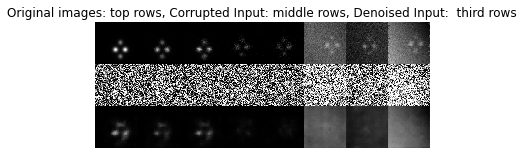

In [2]:
x_decoded = autoencoder.predict(x_train_noisy[:8])
rows, cols = 1, 8
num = rows * cols
imgs = np.concatenate([x_train[:num], x_train_noisy[:num], x_decoded[:num]])
imgs = imgs.reshape((rows * 3, cols, image_size, image_size))
imgs = np.vstack(np.split(imgs, rows, axis=1))
imgs = imgs.reshape((rows * 3, -1, image_size, image_size))
imgs = np.vstack([np.hstack(i) for i in imgs])
imgs = (imgs * 255).astype(np.uint8)
plt.figure()
plt.axis('off')
plt.title('Original images: top rows, '
          'Corrupted Input: middle rows, '
          'Denoised Input:  third rows')
plt.imshow(imgs, interpolation='none', cmap='gray')
Image.fromarray(imgs).save('拜託別鬧趕快過喔.png')
plt.show()


(8, 128, 128, 1) (8, 128, 128, 1) (8, 128, 128, 1)


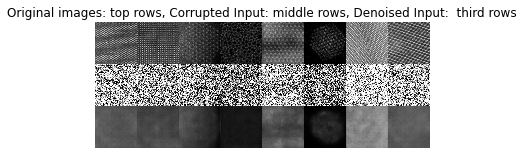

In [3]:
# predict the autoencoder output from corrupted test images

x_decoded = autoencoder.predict(x_test_noisy)

print(x_test.shape,x_test_noisy.shape,x_decoded.shape)
# 3 sets of images with 9 MNIST digits
# 1st rows - original images
# 2nd rows - images corrupted by noise
# 3rd rows - denoised images
rows, cols = 1, 8
num = rows * cols
imgs = np.concatenate([x_test[:num], x_test_noisy[:num], x_decoded[:num]])
imgs = imgs.reshape((rows * 3, cols, image_size, image_size))
imgs = np.vstack(np.split(imgs, rows, axis=1))
imgs = imgs.reshape((rows * 3, -1, image_size, image_size))
imgs = np.vstack([np.hstack(i) for i in imgs])
imgs = (imgs * 255).astype(np.uint8)
plt.figure()
plt.axis('off')
plt.title('Original images: top rows, '
          'Corrupted Input: middle rows, '
          'Denoised Input:  third rows')
plt.imshow(imgs, interpolation='none', cmap='gray')
Image.fromarray(imgs).save('最好長漂亮一點喔.png')
plt.show()
